# Computer Vision

### Libraries

In [2]:
import cv2
from matplotlib import pyplot as plt
from skimage import io
import numpy as np
from PIL import Image
import pickle

### Get frames from the video

In [16]:
def getFrames(path):
    cap= cv2.VideoCapture(path)
    i=0
    while(cap.isOpened()):
        ret, frame = cap.read()
        if ret == False:
            break
        # добавляет в корневую папку и записывает, как kang(i).jpg
        cv2.imwrite('kang'+str(i)+'.jpg',frame)
        i+=1

    cap.release()
    cv2.destroyAllWindows()
getFrames("IMG_0072.MOV")

### Face detection by using cv2 data

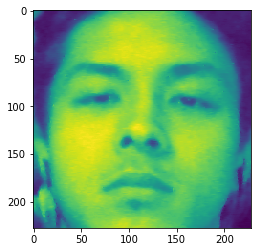

In [6]:
face_cascade = cv2.CascadeClassifier('data/haarcascade_frontalface_alt2.xml')

# Webcam 
cap = cv2.VideoCapture(0)

if not cap.isOpened():
    raise IOError("Cannot open webcam")

try:
    while True:
        ret, frame = cap.read()
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, scaleFactor=1.5, minNeighbors=5)

        # face detection
        for (x, y, w, h) in faces:
            roi_gray = gray[y:y+h, x:x+w] #ycord_start, ycord_end
            roi_color = frame[y:y+h, x:x+w]
            img_item = "face.png"
            cv2.imwrite(img_item, roi_gray)

            color = (0, 0, 255) #BGR
            stroke = 2
            x_end = x + w
            y_end = y + h
            cv2.rectangle(frame, (x, y), (x_end, y_end), color, stroke)

        frame = cv2.resize(frame, None, fx=0.5, fy=0.5, interpolation=cv2.INTER_AREA)
        cv2.imshow('Input', frame)

        c = cv2.waitKey(1)
        if c == 27:
            break

    cap.release()
    cv2.destroyAllWindows()
    
except Exception as e:
    cap.release()
    cv2.destroyAllWindows()
    print(e)

# last face recognition

img = io.imread('face.png')
plt.imshow(img)

### Trainable data (../images/studentFIO/studnetFIO .jpg | .png)

In [19]:
import os

base_dir   = os.path.dirname(os.path.abspath(''))
image_dir  = os.path.join(base_dir, "face-recognition\images")
recognizer = cv2.face.LBPHFaceRecognizer_create()

current_id = 0
label_ids  = {}
y_labels   = []
x_train    = []

for root, dirs, files in os.walk(image_dir):
    for file in files:
        if file.endswith("png") or file.endswith("jpg"):
            path  = os.path.join(root, file)
            label = os.path.basename(os.path.dirname(path)).replace(" ", "-").lower()
            if not label in label_ids:
                label_ids[label] = current_id
                current_id += 1
            id_ = label_ids[label]
            pil_image   = Image.open(path).convert("L") # gray
            final_image = pil_image.resize((550, 550), Image.ANTIALIAS)
            image_array = np.array(pil_image, "uint8")
            faces = face_cascade.detectMultiScale(image_array, scaleFactor=1.5, minNeighbors=5)
            for (x, y, w, h) in faces:
                roi = image_array[y:y+h, x:x+w]
                x_train.append(roi)
                y_labels.append(id_)

with open("labels.pickle", "wb") as f:
    pickle.dump(label_ids, f)
    
recognizer.train(x_train, np.array(y_labels))
recognizer.save("trainer.yml")

### Using recognizer to identify the user

In [23]:
recognizer.read("trainer.yml")
labels = {y:x for x, y in label_ids.items()}

cap = cv2.VideoCapture(0)

if not cap.isOpened():
    raise IOError("Cannot open webcam")

try:
    while True:
        ret, frame = cap.read()
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, scaleFactor=1.5, minNeighbors=5)

        # face detection
        for (x, y, w, h) in faces:
            roi_gray = gray[y:y+h, x:x+w] #ycord_start, ycord_end
            roi_color = frame[y:y+h, x:x+w]

            id_, conf = recognizer.predict(roi_gray)
            if conf >= 45:
                font  = cv2.FONT_HERSHEY_SIMPLEX
                name  = labels[id_]
                color = (0, 0, 255)
                stroke = 2
                cv2.putText(frame, name, (x,y), font, 1, color, stroke, cv2.LINE_AA)
            img_item  = "face.png"
            cv2.imwrite(img_item, roi_gray)

            color = (0, 0, 255) #BGR
            stroke = 2
            x_end = x + w
            y_end = y + h
            cv2.rectangle(frame, (x, y), (x_end, y_end), color, stroke)

#         frame = cv2.resize(frame, None, fx=0.5, fy=0.5, interpolation=cv2.INTER_AREA)
        cv2.imshow('Input', frame)

        c = cv2.waitKey(1)
        if c == 27:
            break

    cap.release()
    cv2.destroyAllWindows()
    
except Exception as e:
    cap.release()
    cv2.destroyAllWindows()
    print(e)